## Imports

In [1]:
!pip install -q seaborn pandas 


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [40]:
from pathlib import Path
import ast
from collections import defaultdict
import math

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from stanza.models.common.doc import Sentence as StanzaSentence, Word as StanzaWord, Token as StanzaToken
from astred import Sentence, AlignedSentences

In [3]:
import warnings
warnings.filterwarnings("error")

## Load data

In [4]:
DATASET_FOLDER = Path() / '..' / 'data' / 'processed'
MERGED_FOLDER = DATASET_FOLDER / 'merged'
MERGED_FOLDER.exists()

True

In [79]:
df = pd.DataFrame()
for lang in ['ukr', 'ara', 'ita', 'nld', 'tur', 'vie']:
    if lang == 'ita':
        lang_df_main_texts = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t4_t5_main_texts.tsv', sep='\t', index_col=0)
        lang_df_main = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t4_t5_main.tsv', sep='\t', index_col=0)
    else:
        lang_df_main_texts = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t2_t3_main_texts.tsv', sep='\t', index_col=0)
        lang_df_main = pd.read_csv(MERGED_FOLDER / f'{lang}_t1_t2_t3_main.tsv', sep='\t', index_col=0)

    lang_df = pd.merge(lang_df_main_texts, lang_df_main, how='inner', on=['unit_id', 'lang_id'])

    df = pd.concat([df, lang_df], ignore_index=False)

    
# filter out not MT samples 
df = df[df['mt_tokens'].notna()]

print(len(df))
df.sample(3)

5160


,src_text,mt_text,tgt_text,aligned_edit,lang_id,src_tokens,src_annotations,mt_tokens,mt_annotations,tgt_tokens,...,doc_id,time_s,time_m,time_h,time_per_char,time_per_word,key_per_char,words_per_hour,words_per_minute,per_subject_visit_order
unit_id,,,,,,,,,,,,,,,,,,,,,
flores101-main-nld-48-pe2-2,A satellite phone is not generally a replaceme...,Een satelliettelefoon is meestal geen vervangi...,Een satelliettelefoon is meestal geen goed alt...,REF: een satelliettelefoon is meestal geen **...,nld,"['A', 'satellite', 'phone', 'is', 'not', 'gene...","[{'lemma': 'a', 'upos': 'DET', 'feats': 'Defin...","['Een', 'satelliettelefoon', 'is', 'meestal', ...","[{'lemma': 'een', 'upos': 'DET', 'feats': 'Def...","['Een', 'satelliettelefoon', 'is', 'meestal', ...",...,48,47.282,0.7880,0.0131,0.2974,1.5252,0.5723,2360.3062,39.3384,212
flores101-main-ita-92-pe1-1,"Out of 1,400 people polled prior to the 2010 f...",Su 1.400 persone intervistate prima delle elez...,Su 1.400 persone intervistate prima delle elez...,REF: su 1.400 persone intervistate prima dell...,ita,"['Out', 'of', '1,400', 'people', 'polled', 'pr...","[{'lemma': 'out', 'upos': 'ADP', 'feats': '', ...","['Su', '1.400', 'persone', 'intervistate', 'pr...","[{'lemma': 'su', 'upos': 'ADP', 'feats': '', '...","['Su', '1.400', 'persone', 'intervistate', 'pr...",...,92,139.188,2.3198,0.0387,0.9942,5.5675,1.0071,646.6075,10.7768,389
flores101-main-ara-42-pe2-2,Virtual team members often function as the poi...,غالباً ما يعمل أعضاء الفريق الافتراضي كمكان ال...,غالباً ما يعمل أعضاء الفريق الافتراضي كنقطة ات...,REF: غالباً ما يعمل أعضاء الفريق الافتراضي كم...,ara,"['Virtual', 'team', 'members', 'often', 'funct...","[{'lemma': 'virtual', 'upos': 'ADJ', 'feats': ...","['غالباً', 'ما', 'يعمل', 'أعضاء', 'الفريق', 'ا...","[{'lemma': 'غَالِب', 'upos': 'ADJ', 'feats': '...","['غالباً', 'ما', 'يعمل', 'أعضاء', 'الفريق', 'ا...",...,42,57.993,0.9666,0.0161,0.6105,3.8662,0.4632,931.1469,15.5191,185


In [80]:
%%time
# process all saved strings to actual lists
df['tgt_tokens'] = df['tgt_tokens'].apply(ast.literal_eval)
df['tgt_annotations'] = df['tgt_annotations'].apply(ast.literal_eval)
df['mt_tokens'] = df['mt_tokens'].apply(ast.literal_eval)
df['mt_annotations'] = df['mt_annotations'].apply(ast.literal_eval)
df['mt_tbd_qe'] = df['mt_tbd_qe'].apply(ast.literal_eval)
df['mt_wmt22_qe'] = df['mt_wmt22_qe'].apply(ast.literal_eval)


def process_alignments(mt_pe_tbd_qe_alignments):
    mt_pe_alignments_dict = defaultdict(list)
    for k, v, score in mt_pe_tbd_qe_alignments:
        if k is not None:
            mt_pe_alignments_dict[k].append(v)
    return mt_pe_alignments_dict
df['mt_pe_tbd_qe_alignments'] = df['mt_pe_tbd_qe_alignments'].apply(ast.literal_eval)
df['mt_pe_tbd_qe_alignments_dict'] = df['mt_pe_tbd_qe_alignments'].apply(process_alignments)

CPU times: user 17.3 s, sys: 414 ms, total: 17.7 s
Wall time: 18.6 s


## Check errors distribution 

In [248]:
# process data: read files, read lists to python lists, read alignments 

error_types_list = []
for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = x['tgt_tokens']
    mt_tokens = x['mt_tokens']
    mt_tbd_qe = x['mt_tbd_qe']
    mt_wmt22_qe = x['mt_wmt22_qe'][:-1]  # as omission rule right
    mt_pe_alignments_dict = x['mt_pe_tbd_qe_alignments_dict']

    for i, mt_tok in enumerate(mt_tokens):
        paired_pe_tok_i = mt_pe_alignments_dict[i][0] if mt_pe_alignments_dict[i] else None  # SUB have to be paired with one PE token
        if paired_pe_tok_i is  None:
            continue

        tbd_qe_tags = mt_tbd_qe[i]

        error_types_list.append({
            'unit_id': _id,
            'lang_id': x['lang_id'],
            'mt_tbd_qe_tags': tbd_qe_tags,
            **{
                error_name: error_name in tbd_qe_tags
                for error_name in ['OK', 'BAD-SUB', 'BAD-INS', 'BAD-CON', 'BAD-EXP', 'BAD-SHF', 'BAD-DEL-R', 'BAD-DEL-L']
            },
        })

df_error_types = pd.DataFrame(error_types_list)

df_error_types

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5160/5160 [00:01<00:00, 2670.68it/s]


,unit_id,lang_id,mt_tbd_qe_tags,OK,BAD-SUB,BAD-INS,BAD-CON,BAD-EXP,BAD-SHF,BAD-DEL-R,BAD-DEL-L
0,flores101-main-ukr-100-pe1-1,ukr,{OK},True,False,False,False,False,False,False,False
1,flores101-main-ukr-100-pe1-1,ukr,{BAD-SUB},False,True,False,False,False,False,False,False
2,flores101-main-ukr-100-pe1-1,ukr,"{BAD-SUB, BAD-DEL-R}",False,True,False,False,False,False,True,False
3,flores101-main-ukr-100-pe1-1,ukr,"{OK, BAD-DEL-L}",True,False,False,False,False,False,False,True
4,flores101-main-ukr-100-pe1-1,ukr,{OK},True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
108478,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108479,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108480,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108481,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False


## Check overlap with wmt22

In [249]:
# process data: read files, read lists to python lists, read alignments 

overlap_list = []
for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = x['tgt_tokens']
    mt_tokens = x['mt_tokens']
    mt_tbd_qe = x['mt_tbd_qe']
    mt_wmt22_qe = x['mt_wmt22_qe'][:-1]  # as omission rule right
    mt_pe_alignments_dict = x['mt_pe_tbd_qe_alignments_dict']

    for i, mt_tok in enumerate(mt_tokens):
        paired_pe_tok_i = mt_pe_alignments_dict[i][0] if mt_pe_alignments_dict[i] else None  # SUB have to be paired with one PE token
        if paired_pe_tok_i is  None:
            continue

        tbd_qe_tags = mt_tbd_qe[i]

        for tbd_qe_tag in tbd_qe_tags:
            overlap_list.append({
                'unit_id': _id,
                'lang_id': x['lang_id'],
                'mt_tok': mt_tok,
                'pe_tok': pe_tokens[paired_pe_tok_i],
                'mt_tbd_qe': tbd_qe_tag,
                'mt_wmt22_qe': mt_wmt22_qe[i],
            })

df_overlap = pd.DataFrame(overlap_list)

df_overlap

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5160/5160 [00:01<00:00, 3504.74it/s]


,unit_id,lang_id,mt_tok,pe_tok,mt_tbd_qe,mt_wmt22_qe
0,flores101-main-ukr-100-pe1-1,ukr,Шок,Шок,OK,OK
1,flores101-main-ukr-100-pe1-1,ukr,при,від,BAD-SUB,BAD
2,flores101-main-ukr-100-pe1-1,ukr,вступі,повернення,BAD-SUB,BAD
3,flores101-main-ukr-100-pe1-1,ukr,вступі,повернення,BAD-DEL-R,BAD
4,flores101-main-ukr-100-pe1-1,ukr,настає,настає,OK,OK
...,...,...,...,...,...,...
141186,flores101-main-vie-48-pe1-4,vie,nối,nối,OK,OK
141187,flores101-main-vie-48-pe1-4,vie,với,với,OK,OK
141188,flores101-main-vie-48-pe1-4,vie,dịch vụ,dịch vụ,OK,OK
141189,flores101-main-vie-48-pe1-4,vie,này,này,OK,OK


In [250]:
print('Note: BAD-DEL and BAD-SHF is overlapping with other cats')
pd.crosstab(
    df_overlap['mt_tbd_qe'], 
    [df_overlap['lang_id'], df_overlap['mt_wmt22_qe']], 
    rownames=['mt_tbd_qe'], 
    colnames=['lang_id', 'mt_wmt22_qe']
)

Note: BAD-DEL and BAD-SHF is overlapping with other cats


lang_id       ara          ita          nld          tur          ukr         \
mt_wmt22_qe   BAD     OK   BAD     OK   BAD     OK   BAD     OK   BAD     OK   
mt_tbd_qe                                                                      
BAD-CON        99      3    68      5    84      2   141      5   149     10   
BAD-DEL-L     576    188   660    186   624    188   456    179  1165    319   
BAD-DEL-R     504    515   566    692   478    635   459    387  1160    757   
BAD-EXP       363      8   177     17   236     16   387     17   599     28   
BAD-INS         0      0     1      0     1      0     0      0     3      1   
BAD-SHF      1237   1090  1082    955  1411   1195  1353    866  2593   1217   
BAD-SUB      2055      0  2366      2  1726      2  2217      0  4294      1   
OK            690  14073   753  17314   992  15895   735  12030  1106  10296   

lang_id       vie         
mt_wmt22_qe   BAD     OK  
mt_tbd_qe                 
BAD-CON       189     23  
BAD-DEL-L    1265    498  
BAD-DEL-R    1133   1282  
BAD-EXP       682     61  
BAD-INS        22      0  
BAD-SHF      2486   2351  
BAD-SUB      2144      2  
OK           1842  14551

In [289]:
df_overlap[(df_overlap['mt_tbd_qe'] == 'OK') & (df_overlap['mt_wmt22_qe'] == 'BAD')].sample(10)

,unit_id,lang_id,mt_tok,pe_tok,mt_tbd_qe,mt_wmt22_qe
133931,flores101-main-vie-25-pe1-2,vie,và,và,OK,BAD
121804,flores101-main-vie-93-pe2-1,vie,của,của,OK,BAD
60478,flores101-main-ita-91-pe2-3,ita,non,non,OK,BAD
14086,flores101-main-ukr-75-pe2-4,ukr,1861,1861,OK,BAD
10197,flores101-main-ukr-28-pe1-3,ukr,Інтернету,Інтернету,OK,BAD
127553,flores101-main-vie-50-pe2-3,vie,đại,đại,OK,BAD
38197,flores101-main-ara-95-pe1-3,ara,الفناء,الفناء,OK,BAD
89619,flores101-main-nld-62-pe2-3,nld,in,in,OK,BAD
100122,flores101-main-tur-107-pe2-4,tur,Avrupa,Avrupa,OK,BAD
10221,flores101-main-ukr-28-pe1-4,ukr,стосунки,стосунки,OK,BAD


In [87]:
df_overlap[(df_overlap['mt_tbd_qe'] == 'BAD-EXP') & (df_overlap['mt_wmt22_qe'] == 'OK')].sample(5)

,unit_id,lang_id,mt_tok,pe_tok,mt_tbd_qe,mt_wmt22_qe
116969,flores101-main-vie-46-pe1-2,vie,chính phủ,chính phủ,BAD-EXP,OK
105196,flores101-main-tur-89-pe2-1,tur,büyürken,büyürken,BAD-EXP,OK
126690,flores101-main-vie-41-pe1-1,vie,khoa học,cơ bản,BAD-EXP,OK
119938,flores101-main-vie-75-pe2-2,vie,địa điểm,kỳ nghỉ,BAD-EXP,OK
111608,flores101-main-tur-85-pe1-2,tur,.,.,BAD-EXP,OK


In [259]:
pd.crosstab(
    df_overlap['mt_tbd_qe'], 
    df_overlap['mt_wmt22_qe'],
).T[['OK', 'BAD-SUB', 'BAD-INS', 'BAD-CON', 'BAD-EXP', 'BAD-SHF', 'BAD-DEL-R', 'BAD-DEL-L']]

mt_tbd_qe,OK,BAD-SUB,BAD-INS,BAD-CON,BAD-EXP,BAD-SHF,BAD-DEL-R,BAD-DEL-L
mt_wmt22_qe,,,,,,,,
BAD,6118,14802,27,730,2444,10162,4300,4746
OK,84159,7,1,48,147,7674,4268,1558


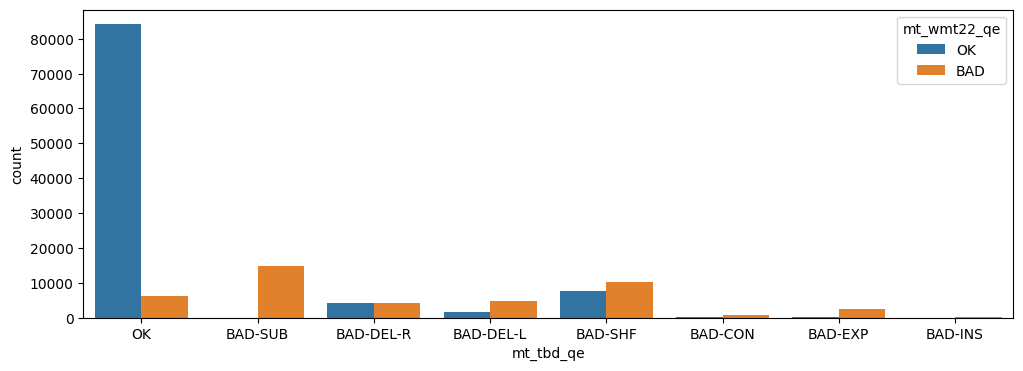

In [91]:
plt.figure(figsize=(12, 4))
sns.countplot(
    df_overlap,
    x='mt_tbd_qe',
    hue='mt_wmt22_qe',
)
plt.show()

## Analyse BAD-SUB

In [95]:
# collect all BAD-SUB: read files, filter sents with BAD-SUB token, process to python lists, read alignments

stats_list = []
for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = x['tgt_tokens']
    pe_annotations = x['tgt_annotations']
    mt_tokens = x['mt_tokens']
    mt_annotations = x['mt_annotations']
    mt_tbd_qe = x['mt_tbd_qe']
    mt_wmt22_qe = x['mt_wmt22_qe'][:-1]  # as omission rule right
    mt_pe_alignments_dict = x['mt_pe_tbd_qe_alignments_dict']
            
    for i, mt_tok in enumerate(mt_tokens):
        if 'BAD-SUB' in mt_tbd_qe[i]:
            paired_pe_tok_i = mt_pe_alignments_dict[i][0] if mt_pe_alignments_dict[i] else None  # SUB have to be paired with one PE token
            if paired_pe_tok_i is  None:
                continue

            stats_list.append({
                'unit_id': _id,
                'lang_id': x['lang_id'],
                'mt_tok': mt_tok,
                'pe_tok': pe_tokens[paired_pe_tok_i],
                'mt_pos': mt_annotations[i]['upos'],
                'pe_pos': pe_annotations[paired_pe_tok_i]['upos'],
                'same_word': mt_tok.lower() == pe_tokens[paired_pe_tok_i].lower(),
                'same_pos': mt_annotations[i]['upos'] == pe_annotations[paired_pe_tok_i]['upos'],
                'same_lemma': mt_annotations[i]['lemma'] == pe_annotations[paired_pe_tok_i]['lemma'],
                'same_morf': mt_annotations[i]['feats'] == pe_annotations[paired_pe_tok_i]['feats'],
                'same_deprel': mt_annotations[i]['deprel'] == pe_annotations[paired_pe_tok_i]['deprel'],
            })

df_stats = pd.DataFrame(stats_list)
df_stats = df_stats.astype({'same_word': bool, 'same_pos': bool, 'same_lemma': bool, 'same_morf': bool, 'same_deprel': bool})

df_stats

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5160/5160 [00:00<00:00, 8042.61it/s]


,unit_id,lang_id,mt_tok,pe_tok,mt_pos,pe_pos,same_word,same_pos,same_lemma,same_morf,same_deprel
0,flores101-main-ukr-100-pe1-1,ukr,при,від,ADP,ADP,False,True,False,False,True
1,flores101-main-ukr-100-pe1-1,ukr,вступі,повернення,NOUN,NOUN,False,True,False,False,False
2,flores101-main-ukr-100-pe1-1,ukr,фази,фаза,NOUN,NOUN,False,True,True,False,False
3,flores101-main-ukr-100-pe1-1,ukr,бути,проходити,AUX,VERB,False,False,False,True,False
4,flores101-main-ukr-100-pe1-3,ukr,Повернувшись,Проживши,VERB,VERB,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
14804,flores101-main-vie-48-pe1-3,vie,bằng,trên,ADP,ADP,False,True,False,True,True
14805,flores101-main-vie-48-pe1-3,vie,vận chuyển,tàu thuyền,VERB,NOUN,False,False,False,True,False
14806,flores101-main-vie-48-pe1-3,vie,cuộc,đoàn,NOUN,NOUN,False,True,False,True,True
14807,flores101-main-vie-48-pe1-3,vie,thoại,truyền,NOUN,VERB,False,False,False,True,True


---

In [97]:
# precalculate df for charts: count same_pos, diff_pos, total_sub
df_stats_ext = df_stats[['unit_id', 'lang_id', 'same_pos']].copy()
df_stats_ext['diff_pos'] = ~df_stats_ext['same_pos']
df_stats_ext['total_sub'] = 1
df_stats_ext_sum = df_stats_ext.groupby(['unit_id', 'lang_id'])[['total_sub', 'diff_pos', 'same_pos']].sum()
df_stats_ext_sum = df_stats_ext_sum[(df_stats_ext_sum['total_sub'] < 10) & (df_stats_ext_sum['diff_pos'] < 6)]
df_stats_ext_sum['diff_pos_percent'] = df_stats_ext_sum['diff_pos'] / df_stats_ext_sum['total_sub']
df_stats_ext_sum

,,total_sub,diff_pos,same_pos,diff_pos_percent
unit_id,lang_id,,,,
flores101-main-ara-1-pe1-1,ara,3,1,2,0.333333
flores101-main-ara-1-pe1-4,ara,2,2,0,1.000000
flores101-main-ara-1-pe2-2,ara,5,3,2,0.600000
flores101-main-ara-1-pe2-3,ara,1,0,1,0.000000
flores101-main-ara-1-pe2-4,ara,3,2,1,0.666667
...,...,...,...,...,...
flores101-main-vie-99-pe1-4,vie,1,1,0,1.000000
flores101-main-vie-99-pe2-1,vie,3,0,3,0.000000
flores101-main-vie-99-pe2-2,vie,3,1,2,0.333333


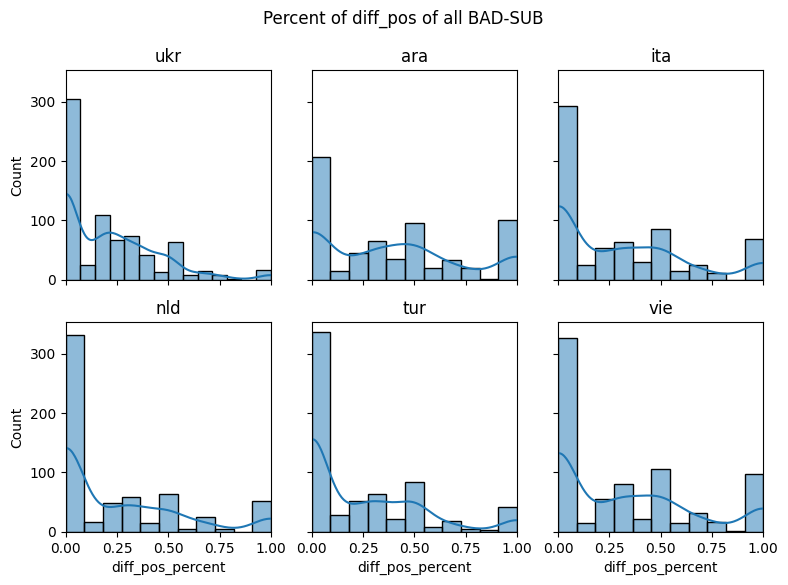

In [98]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

for ax, lang in zip(axes.flat, df['lang_id'].unique()):

    sns.histplot(
        df_stats_ext_sum.loc[(slice(None),lang), :],
        x="diff_pos_percent",
        kde=True,
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(0, 1))
f.suptitle("Percent of diff_pos of all BAD-SUB", fontsize=12)
plt.show()

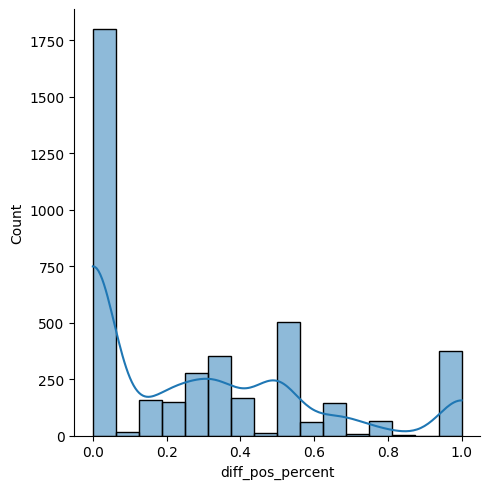

In [99]:
sns.displot(
    df_stats_ext_sum,
    x="diff_pos_percent",
    kde=True,
)

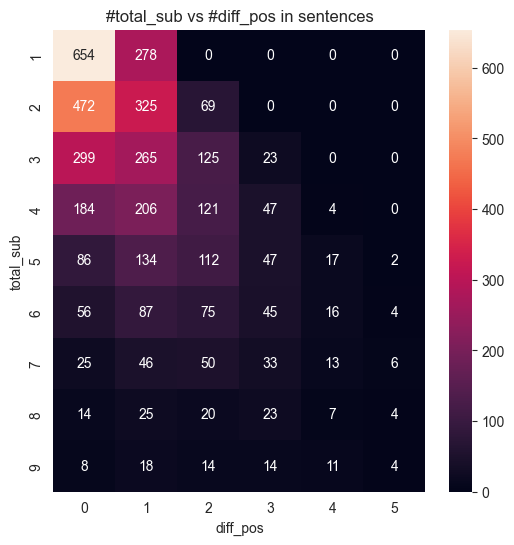

In [415]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    pd.crosstab(df_stats_ext_sum['total_sub'], df_stats_ext_sum['diff_pos']),
    annot=True,
    fmt=".0f",
).set(title='#total_sub vs #diff_pos in sentences')
plt.show()

## Analyse Syntax Trees (using Stanza & Tree Edit Distance)

In [101]:
# process saved stanza sentences to original format

def list_to_stanza_sentence(token_list, annotations_list) -> StanzaSentence:
    tokens = []
    for i, (token, anotation) in enumerate(zip(token_list, annotations_list), start=1):
        token_dict = dict(
            id=i,
            text=token,
            lemma=anotation.get('lemma'),
            upos=anotation.get('upos'),
            xpos=anotation.get('xpos'),
            feats=anotation.get('feats'),
            head=anotation.get('head'),
            deprel=anotation.get('deprel'),
            misc='start_char={}|end_char={}'.format(anotation.get('start_char'), anotation.get('end_char')),
            ner=anotation.get('ner'),
        )

        tokens.append(token_dict)

    sentence = StanzaSentence(tokens=tokens)
    return sentence

In [102]:
# use astred to calculate tree edit distance

langs = {
    'vie': 'vi',
    'tur': 'tr',
    'ukr': 'uk',
    'ara': 'ar',
    'ita': 'it',
    'nld': 'nl',
}

synt_scores_list = []

for _id, x in tqdm(df.iterrows(), total=len(df)):
    pe_tokens = x['tgt_tokens']
    pe_annotations = x['tgt_annotations']
    mt_tokens = x['mt_tokens']
    mt_annotations = x['mt_annotations']
    mt_tbd_qe = x['mt_tbd_qe']
    mt_pe_alignments_dict = x['mt_pe_tbd_qe_alignments_dict']
    mt_pe_alignments_pairs = [(k, v[0]) for k, v in mt_pe_alignments_dict.items() if len(v) > 0 and v[0] is not None]

    # fix 2 sentences examples with 2 heads to be 1 headed (match to first head
    def _to_int(x, max_value = None):
        try:
            values = [int(i) for i in x.split('+')]
            if 0 in values:
                val = 0
            else:
                val = values[0]
        except AttributeError:
            val = int(x)
        if max_value:
            # fix index error when some tree indexes greater than tree length
            val = min(val, max_value)
        return val

    try:
        mt_annotations = [{**annotation, 'head': _to_int(annotation['head'], max_value=len(mt_annotations)-1)} for annotation in mt_annotations]
        first_head, *other_heads = [i for i, annotation in enumerate(mt_annotations) if annotation['head'] == 0]
        mt_annotations = [{**annotation, 'head': first_head} if i in other_heads else annotation for i, annotation in enumerate(mt_annotations)]

        pe_annotations = [{**annotation, 'head': _to_int(annotation['head'], max_value=len(pe_annotations)-1)} for annotation in pe_annotations]
        first_head, *other_heads = [i for i, annotation in enumerate(pe_annotations) if annotation['head'] == 0]
        pe_annotations = [{**annotation, 'head': first_head} if i in other_heads else annotation for i, annotation in enumerate(pe_annotations)]
    except ValueError:
        print('VALUE ERROR')
        print('mt_annotations', [i['head'] for i in mt_annotations])
        print('pe_annotations', [i['head'] for i in pe_annotations])
        _df_synt_scores = pd.DataFrame([{
            'unit_id': _id,
            'lang_id': x['lang_id'],
            'ted': None,
        }])
        df_synt_scores = pd.concat([df_synt_scores, _df_synt_scores], ignore_index=True)
        continue

    try:
        sent_mt = Sentence.from_parser(list_to_stanza_sentence(mt_tokens, mt_annotations))
        sent_pe = Sentence.from_parser(list_to_stanza_sentence(pe_tokens, pe_annotations))

        aligned = AlignedSentences(
            sent_mt,
            sent_pe,
            word_aligns=mt_pe_alignments_pairs,
        )
        ted = aligned.ted
    except IndexError:
        print('INDEX ERROR')
        print('mt_annotations', [i['head'] for i in mt_annotations])
        print('pe_annotations', [i['head'] for i in pe_annotations])
        ted = None

    synt_scores_list.append({
        'unit_id': _id,
        'lang_id': x['lang_id'],
        'ted': int(ted),
    })

df_synt_scores = pd.DataFrame(synt_scores_list)
df_synt_scores['ted'] = df_synt_scores['ted'].astype(int)

df_synt_scores

  7%|█████████▌                                                                                                                     | 386/5160 [00:28<05:09, 15.44it/s]17-Sep 19:56:12 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
17-Sep 19:56:12 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
 14%|█████████████████▊                                                                                                             | 722/5160 [00:54<09:39,  7.66it/s]17-Sep 19:56:38 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
17-Sep 19:56:38 - [WARNING]: Can only create a tree for a sentence if it has one (and only one) root (Word.is_root). A tree for this sentence was not created.
 14%|██████████████████▏      

,unit_id,lang_id,ted
0,flores101-main-ukr-100-pe1-1,ukr,14
1,flores101-main-ukr-100-pe1-2,ukr,4
2,flores101-main-ukr-100-pe1-3,ukr,9
3,flores101-main-ukr-100-pe1-4,ukr,12
4,flores101-main-ukr-100-pe1-5,ukr,14
...,...,...,...
5155,flores101-main-vie-106-pe2-4,vie,16
5156,flores101-main-vie-48-pe1-1,vie,11
5157,flores101-main-vie-48-pe1-2,vie,27
5158,flores101-main-vie-48-pe1-3,vie,16


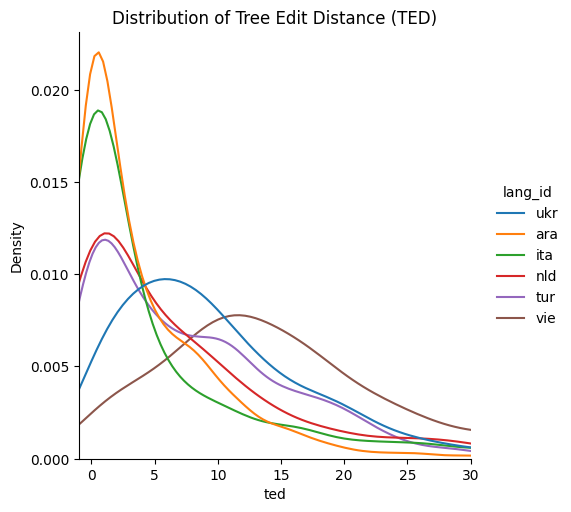

In [116]:
g = sns.displot(
    df_synt_scores,
    x="ted",
    hue="lang_id",
    # kde=True,
    kind='kde',
    # log_scale=(False, 2),
    multiple="layer",
    # alpha=0.1,
    # facet_kws={'hist_kws':dict(alpha=0.1)}
)
plt.xlim(-1, 30)
plt.ylim(0, None)
plt.title('Distribution of Tree Edit Distance (TED)')
plt.show()

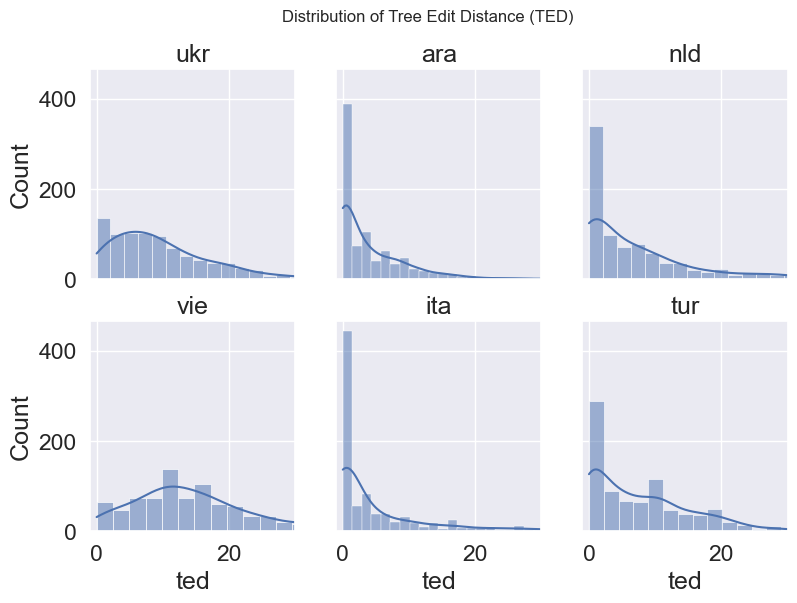

In [290]:

f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

# langs = df['lang_id'].unique()
langs = ['ukr', 'ara', 'nld', 'vie', 'ita', 'tur']
for ax, lang in zip(axes.flat, langs):
    #
    # # Create a cubehelix colormap to use with kdeplot
    # cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.histplot(
        df_synt_scores[df_synt_scores['lang_id'] == lang],
        x="ted",
        kde=True,
        # log_scale=(False, 2),
        multiple="layer",
        # alpha=0.25,
        # facet_kws={'hist_kws':dict(alpha=0.1)}
        stat='count',
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(-1, 30))
f.suptitle("Distribution of Tree Edit Distance (TED)", fontsize=12)
plt.show()

In [286]:
df_synt_scores['mt_tbd_bad_count'] = df['mt_tbd_qe'].apply(lambda x: sum(len(i - {'OK', 'BAD-DEL-R'}) for i in x)).values
df_synt_scores.sample(5)

,unit_id,lang_id,ted,mt_tbd_bad_count
3812,flores101-main-tur-16-pe2-3,tur,11,9
2849,flores101-main-nld-101-pe1-3,nld,57,18
4357,flores101-main-vie-19-pe1-4,vie,8,7
3288,flores101-main-nld-53-pe1-1,nld,10,8
3750,flores101-main-tur-15-pe1-3,tur,4,3


In [287]:
print('Pearson correlation')
df_synt_scores.groupby('lang_id')[['ted', 'mt_tbd_bad_count']].corr(method='pearson').loc[(slice(None),'ted'), 'mt_tbd_bad_count']

Pearson correlation


lang_id     
ara      ted    0.539678
ita      ted    0.442620
nld      ted    0.734874
tur      ted    0.726095
ukr      ted    0.776998
vie      ted    0.707215
Name: mt_tbd_bad_count, dtype: float64

Note: BAD count


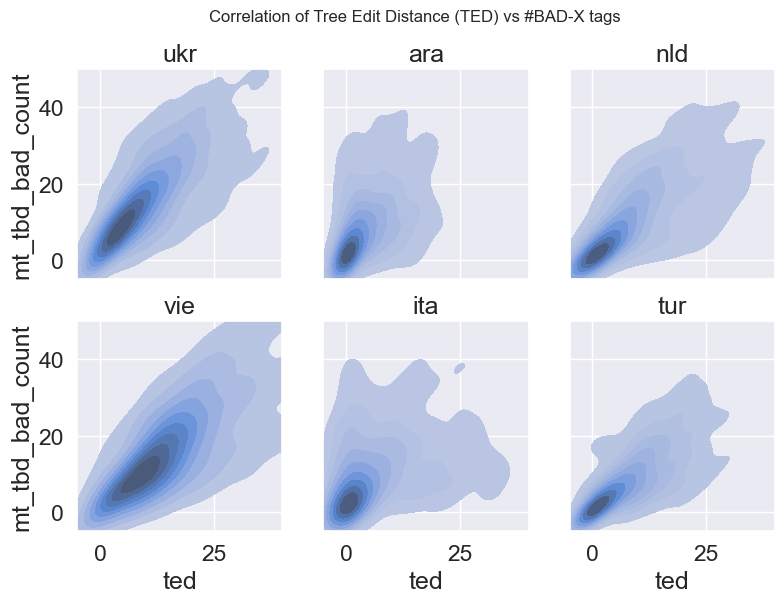

In [288]:
print('Note: BAD count')

f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

# langs = df['lang_id'].unique()
langs = ['ukr', 'ara', 'nld', 'vie', 'ita', 'tur']
for ax, lang in zip(axes.flat, langs):
    #
    # # Create a cubehelix colormap to use with kdeplot
    # cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.kdeplot(
        df_synt_scores[df_synt_scores['lang_id'] == lang],
        x="ted",
        y="mt_tbd_bad_count",
        # cmap=None,
        fill=True,
        # clip=(-5, 5),
        # cut=10,
        # thresh=0,
        # levels=15,
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(-5, 40), ylim=(-5, 50))
f.suptitle("Correlation of Tree Edit Distance (TED) vs #BAD-X tags", fontsize=12)
plt.show()

In [280]:
df_synt_scores['mt_tbd_bad_count'] = df['mt_tbd_qe'].apply(lambda x: sum(len(i - {'OK', 'BAD-DEL-L', 'BAD-DEL-R', 'BAD-SHF'}) for i in x)).values
df_synt_scores.sample(5)

,unit_id,lang_id,ted,mt_tbd_bad_count
3702,flores101-main-tur-98-pe1-1,tur,0,0
77,flores101-main-ukr-28-pe2-4,ukr,36,23
2904,flores101-main-nld-15-pe1-3,nld,3,1
2644,flores101-main-nld-28-pe1-1,nld,0,0
1855,flores101-main-ita-56-pe2-2,ita,0,2


In [281]:
print('Pearson correlation')
df_synt_scores.groupby('lang_id')[['ted', 'mt_tbd_bad_count']].corr(method='pearson').loc[(slice(None),'ted'), 'mt_tbd_bad_count']

Pearson correlation


lang_id     
ara      ted    0.556922
ita      ted    0.434015
nld      ted    0.669098
tur      ted    0.689409
ukr      ted    0.710757
vie      ted    0.642947
Name: mt_tbd_bad_count, dtype: float64

Note: BAD count except for BAD-DEL and BAD-SHF


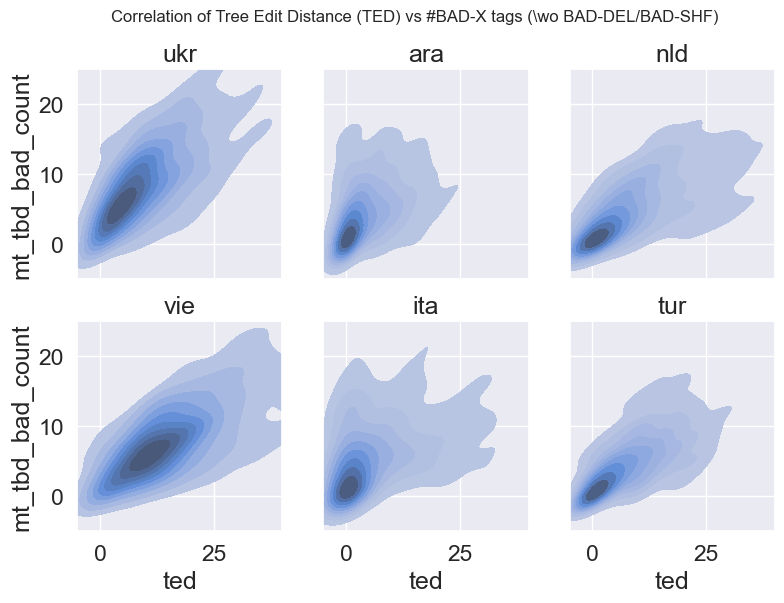

In [282]:
print('Note: BAD count except for BAD-DEL and BAD-SHF')

f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

# langs = df['lang_id'].unique()
langs = ['ukr', 'ara', 'nld', 'vie', 'ita', 'tur']
for ax, lang in zip(axes.flat, langs):
    #
    # # Create a cubehelix colormap to use with kdeplot
    # cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.kdeplot(
        df_synt_scores[df_synt_scores['lang_id'] == lang],
        x="ted",
        y="mt_tbd_bad_count",
        # cmap=None,
        fill=True,
        # clip=(-5, 5),
        # cut=10,
        # thresh=0,
        # levels=15,
        ax=ax,
    )
    ax.set_title(lang)
    # ax.set_axis_off()

ax.set(xlim=(-5, 40), ylim=(-5, 25))
f.suptitle("Correlation of Tree Edit Distance (TED) vs #BAD-X tags (\\wo BAD-DEL/BAD-SHF)", fontsize=12)
plt.show()

---

In [227]:
import matplotlib.ticker as ticker


def plot_summary_df(summary_df, title=''):
    try:
        summary_df = summary_df.drop(['TOTAL', 'AVG'], axis=0)
    except KeyError:
        pass

    sns.set_theme(style="whitegrid")
    sns.set(font_scale=1.5)

    # Make the PairGrid
    g = sns.PairGrid(
        # summary_df.reset_index().sort_values("total (same pos)", ascending=False),
        summary_df.reset_index(),
        x_vars=summary_df.columns,
        y_vars=["lang_id"],
        height=10,
        aspect=.3,
    )

    # Draw a dot plot using the stripplot function
    g.map(
        sns.stripplot,
        size=10,
        orient="h",
        jitter=False,
        palette="flare_r",
        linewidth=1,
        edgecolor="w",
    )

    if title:
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(title)

    # Calculate the average for each column and draw a horizontal line
    for ax, col in zip(g.axes.flat, summary_df.columns):
        avg = summary_df[col].mean()
        ax.axvline(avg, color='r', linestyle='--')
        
        if 'total' not in title:
            continue

        step = 1
        if summary_df[col].max() > 15000:
            step = 10000
        elif summary_df[col].max() > 10000:
            step = 5000
        elif summary_df[col].max() > 5000:
            step = 2500
        elif summary_df[col].max() > 2000:
            step = 1000
        elif summary_df[col].max() > 800:
            step = 500
        elif summary_df[col].max() > 500:
            step = 100
        elif summary_df[col].max() > 1:
            step = 50
        else:
            step = 1
            
        ax.set_xticks(np.arange(0, summary_df[col].max(), step=step))
        ax.xaxis.set_major_formatter(ticker.EngFormatter())


    # setup axis limits
    g.set(xlim=(0, None), xlabel="Count", ylabel="")
    for ax, title in zip(g.axes.flat, list(summary_df.columns)):
        ax.set(title=title)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        if 'total' not in title:
            # ax.set_xlim(0, 1)
            ax.set_xlabel('Rate')

    sns.despine(left=True, bottom=True)

In [228]:
df_stats

,unit_id,lang_id,mt_tok,pe_tok,mt_pos,pe_pos,same_word,same_pos,same_lemma,same_morf,same_deprel
0,flores101-main-ukr-100-pe1-1,ukr,при,від,ADP,ADP,False,True,False,False,True
1,flores101-main-ukr-100-pe1-1,ukr,вступі,повернення,NOUN,NOUN,False,True,False,False,False
2,flores101-main-ukr-100-pe1-1,ukr,фази,фаза,NOUN,NOUN,False,True,True,False,False
3,flores101-main-ukr-100-pe1-1,ukr,бути,проходити,AUX,VERB,False,False,False,True,False
4,flores101-main-ukr-100-pe1-3,ukr,Повернувшись,Проживши,VERB,VERB,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
14804,flores101-main-vie-48-pe1-3,vie,bằng,trên,ADP,ADP,False,True,False,True,True
14805,flores101-main-vie-48-pe1-3,vie,vận chuyển,tàu thuyền,VERB,NOUN,False,False,False,True,False
14806,flores101-main-vie-48-pe1-3,vie,cuộc,đoàn,NOUN,NOUN,False,True,False,True,True
14807,flores101-main-vie-48-pe1-3,vie,thoại,truyền,NOUN,VERB,False,False,False,True,True


In [229]:
df_error_types

,unit_id,lang_id,mt_tbd_qe_tags,OK,BAD-SUB,BAD-DEL-R,BAD-DEL-L,BAD-SHF,BAD-CON,BAD-EXP,BAD-INS
0,flores101-main-ukr-100-pe1-1,ukr,{OK},True,False,False,False,False,False,False,False
1,flores101-main-ukr-100-pe1-1,ukr,{BAD-SUB},False,True,False,False,False,False,False,False
2,flores101-main-ukr-100-pe1-1,ukr,"{BAD-SUB, BAD-DEL-R}",False,True,True,False,False,False,False,False
3,flores101-main-ukr-100-pe1-1,ukr,"{OK, BAD-DEL-L}",True,False,False,True,False,False,False,False
4,flores101-main-ukr-100-pe1-1,ukr,{OK},True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
108478,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108479,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108480,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False
108481,flores101-main-vie-48-pe1-4,vie,{OK},True,False,False,False,False,False,False,False


In [230]:
_df_stats[_df_stats['BAD-SUB']].groupby(['lang_id']).size()

lang_id
ara    2055
ita    2368
nld    1728
tur    2217
ukr    4295
vie    2146
dtype: int64

In [246]:
_df_stats = df_error_types[~df_error_types['OK']]

print('TOTAL:\t', len(_df_stats))

_total = _df_stats.groupby(['lang_id']).size()
tmp = pd.DataFrame([
    _total,
    *[    
        _df_stats[_df_stats[i]].groupby(['lang_id']).size() / _total
        for i in ['BAD-SUB', 'BAD-INS', 'BAD-CON', 'BAD-EXP', 'BAD-SHF', 'BAD-DEL-R', 'BAD-DEL-L']
    ],
], index=[
    'total',
    *['BAD-SUB', 'BAD-INS', 'BAD-CON', 'BAD-EXP', 'BAD-SHF', 'BAD-DEL-R', 'BAD-DEL-L']
]).fillna(0).T.apply(lambda x: round(x, 4)) #.astype('int').T
tmp.loc['TOTAL'] = tmp.sum(numeric_only=True).astype('float')
tmp.loc['AVG'] = (tmp.loc['TOTAL'] / len(set(_df_stats['lang_id']) - {'TOTAL'})).astype('float')
tmp['total'] = tmp['total'].astype('int')

# print(tmp)
tmp

TOTAL:	 18206


,total,BAD-SUB,BAD-INS,BAD-CON,BAD-EXP,BAD-SHF,BAD-DEL-R,BAD-DEL-L
lang_id,,,,,,,,
ara,2528,0.812900,0.00000,0.0403,0.146800,0.308900,0.164200,0.13410
ita,2636,0.898300,0.00040,0.0277,0.073600,0.232900,0.175600,0.13510
nld,2067,0.836000,0.00050,0.0416,0.121900,0.352700,0.159200,0.14510
tur,2767,0.801200,0.00000,0.0528,0.146000,0.289500,0.139500,0.10010
ukr,5085,0.844600,0.00080,0.0313,0.123300,0.365000,0.185100,0.16180
vie,3123,0.687200,0.00700,0.0679,0.237900,0.414300,0.252000,0.18570
TOTAL,18206,4.880200,0.00870,0.2616,0.849500,1.963300,1.075600,0.86190
AVG,3034,0.813367,0.00145,0.0436,0.141583,0.327217,0.179267,0.14365


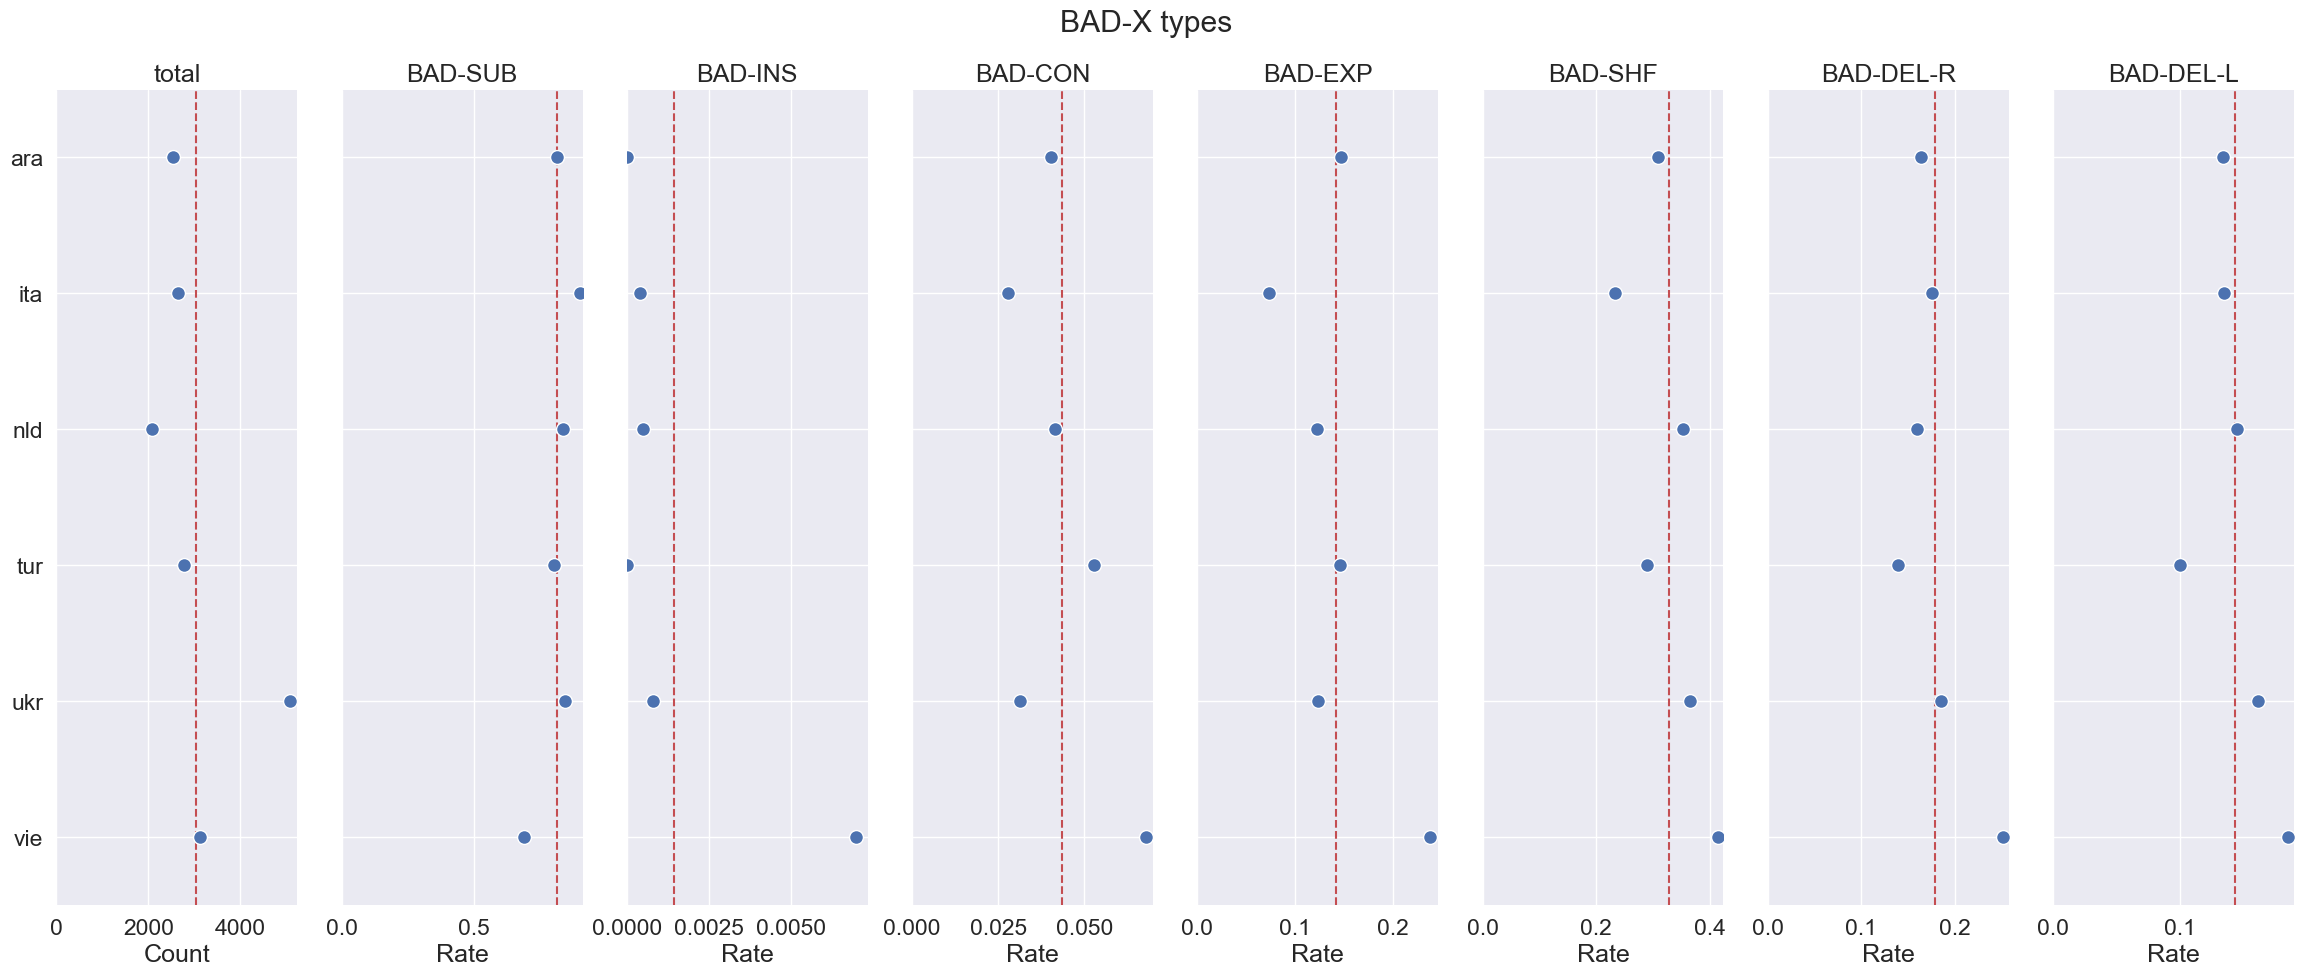

In [247]:
plot_summary_df(tmp, title='BAD-X types')

In [240]:
_df_stats = df_stats

print('TOTAL:\t', len(_df_stats))
print('SAME POS:\t', len(_df_stats[_df_stats['same_pos']]))
print('DIFF POS:\t', len(_df_stats[~_df_stats['same_pos']]))

_total_sub = _df_stats.groupby(['lang_id']).size()
tmp = pd.DataFrame([
    _df_stats.groupby(['lang_id']).size(),
    _df_stats[_df_stats['same_pos']].groupby(['lang_id']).size() / _total_sub,
    _df_stats[~_df_stats['same_pos']].groupby(['lang_id']).size() / _total_sub,
    _df_stats[~_df_stats['same_deprel']].groupby(['lang_id']).size() / _total_sub,
], index=[
    'total',
    'same_pos',
    'diff_pos',
    'diff_deprel',
]).fillna(0).T.apply(lambda x: round(x, 4)) #.astype('int').T
tmp.loc['TOTAL'] = tmp.sum(numeric_only=True).astype('float')
tmp.loc['AVG'] = (tmp.loc['TOTAL'] / len(set(_df_stats['lang_id']) - {'TOTAL'})).astype('float')
tmp['total'] = tmp['total'].astype('int')

# print(tmp)
tmp

TOTAL:	 14809
SAME POS:	 10820
DIFF POS:	 3989


,total,same_pos,diff_pos,diff_deprel
lang_id,,,,
ara,2055,0.598500,0.401500,0.499800
ita,2368,0.718800,0.281200,0.363600
nld,1728,0.752900,0.247100,0.347200
tur,2217,0.760000,0.240000,0.486700
ukr,4295,0.797400,0.202600,0.382100
vie,2146,0.688300,0.311700,0.567100
TOTAL,14809,4.315900,1.684100,2.646500
AVG,2468,0.719317,0.280683,0.441083


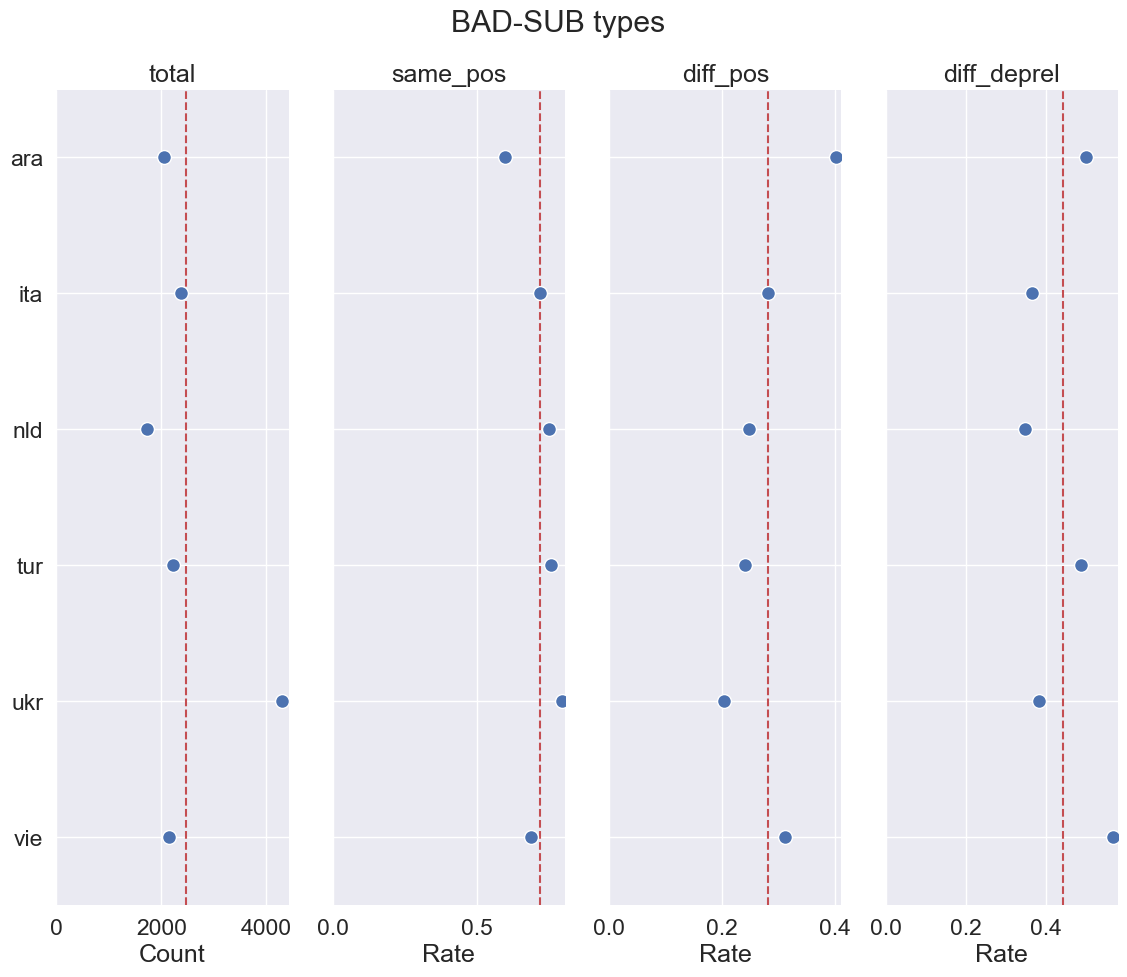

In [241]:
plot_summary_df(tmp, title='BAD-SUB types')

In [238]:
_df_stats = df_stats[df_stats['same_pos']]
print('TOTAL:\t', len(_df_stats))

_total = _df_stats.groupby(['lang_id']).size()
tmp = pd.DataFrame([
    _total_sub,
    _df_stats[_df_stats['same_lemma'] & _df_stats['same_morf']].groupby(['lang_id']).size() / _total,
    _df_stats[_df_stats['same_lemma'] & ~_df_stats['same_morf']].groupby(['lang_id']).size() / _total,
    _df_stats[~_df_stats['same_lemma'] & _df_stats['same_morf']].groupby(['lang_id']).size() / _total,
    _df_stats[~_df_stats['same_lemma'] & ~_df_stats['same_morf']].groupby(['lang_id']).size() / _total,
    _df_stats[_df_stats['same_word']].groupby(['lang_id']).size() / _total,
], index=[
    'total (same pos)',
    'same_lemma same_morf',
    'same_lemma diff_morf',
    'diff_lemma same_morf',
    'diff_lemma diff_morf',
    'same_word (diff case)',
]).fillna(0).T.apply(lambda x: round(x, 4)) #.astype('int').T
tmp.loc['TOTAL'] = tmp.sum(numeric_only=True).astype('float')
tmp.loc['AVG'] = (tmp.loc['TOTAL'] / len(set(_df_stats['lang_id']) - {'TOTAL'})).astype('float')
tmp['total (same pos)'] = tmp['total (same pos)'].astype('int')

# print(tmp)
tmp

TOTAL:	 10820


,total (same pos),same_lemma same_morf,same_lemma diff_morf,diff_lemma same_morf,diff_lemma diff_morf,same_word (diff case)
lang_id,,,,,,
ara,2055,0.0756,0.304100,0.4049,0.215400,0.000000
ita,2368,0.0588,0.293800,0.4142,0.233300,0.040000
nld,1728,0.1176,0.076900,0.6664,0.139100,0.087600
tur,2217,0.0682,0.369700,0.3585,0.203600,0.046900
ukr,4295,0.0374,0.339900,0.3115,0.311200,0.036200
vie,2146,0.0000,0.000000,0.9939,0.006100,0.108300
TOTAL,14809,0.3576,1.384400,3.1494,1.108700,0.319000
AVG,2468,0.0596,0.230733,0.5249,0.184783,0.053167


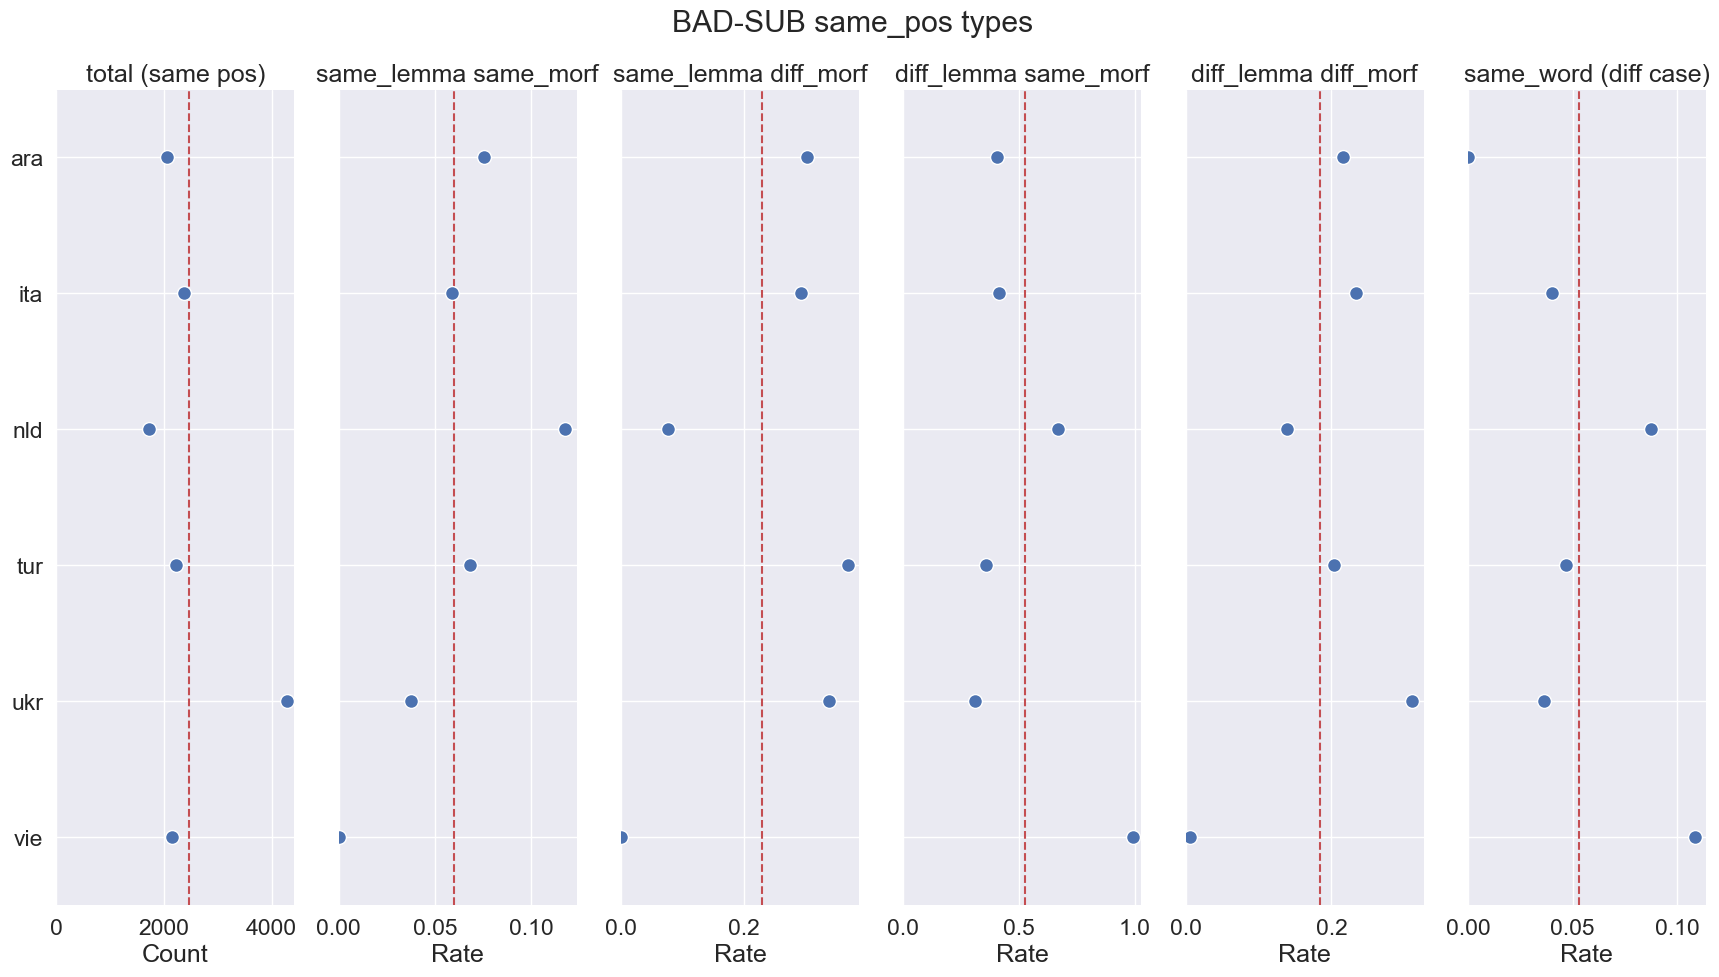

In [239]:
plot_summary_df(tmp, title='BAD-SUB same_pos types')

---